In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.linear_model import LinearRegression

# handling data practise

In [2]:
#loading data
#float cast bc int has no NaN int in pandas
data = pd.read_csv("Covid19Casos.csv",sep=",",quotechar='"',dtype={"sexo":str,"edad": float,"edad_años_meses":str,
                   "clasificacion_resumen":str},
                   usecols=["sexo","edad","edad_años_meses","clasificacion_resumen"],na_values=[''])
data = data[data["edad"] > 0]
data = data[data["clasificacion_resumen"] == "Confirmado"]
#conversion to dataframe
df = pd.DataFrame(data)
#months to years conversion
filt_df1 = (df.edad_años_meses=="Meses")
df.loc[filt_df1, 'edad'] /= 12 
#sex NR filter as well
filt_df3 = (df.sexo!="NR")
df = df.loc[filt_df3]
#conversion of pd to numpy array instead of list bc speed
edades = df.edad.to_numpy() 

Text(0, 0.5, 'Casos')

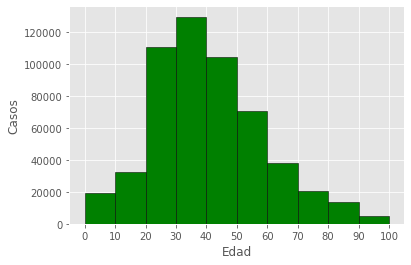

In [3]:
plt.style.use('ggplot')
hist,bins,patches = plt.hist(edades,bins=10,facecolor='green',range=[0,100],histtype='bar', ec='black')
plt.xticks(range(0,110,10))
plt.xlabel('Edad')
plt.ylabel('Casos')

# dates of symptoms, of case opening, of last report + analysis

In [4]:
data = pd.read_csv("Covid19Casos.csv",sep=",",quotechar='"', dtype={"clasificacion_resumen":str},
                   usecols=["fecha_inicio_sintomas","fecha_apertura","clasificacion_resumen"],
                   parse_dates=["fecha_inicio_sintomas","fecha_apertura"],na_values=['']) #data loading
data = data[data["clasificacion_resumen"] == "Confirmado"] #filter confirmed cases
df = pd.DataFrame(data) #converting to dataframe for use
df = df.drop(['clasificacion_resumen'], axis=1) #drop clasificacion_resumen bc previous filter of confirmed cases
filt_df1 = (df.fecha_inicio_sintomas.isnull()) #filter fecha_inicio_sintomas = inexistant
df.loc[filt_df1, "fecha_inicio_sintomas"] = df.loc[filt_df1,"fecha_apertura"] #change fecha_inicio_sintomas = inexistant to fecha_apertura

In [5]:
inicio_epidemia = min(df["fecha_inicio_sintomas"]) #first symptoms of a person registered
ultima_actualizacion_sintomas = max(df["fecha_inicio_sintomas"]) #last day symptoms of a person registered
ultima_actualizacion_apertura = max(df["fecha_apertura"])
df["fecha_inicio_sintomas"] -= inicio_epidemia #correcting by inicio_epidemia 
df["fecha_apertura"] -= inicio_epidemia #correcting by inicio_epidemia
df.fecha_inicio_sintomas = df.fecha_inicio_sintomas.dt.days #change to int, ditch days 
df.fecha_apertura = df.fecha_apertura.dt.days #change to int, ditch days
print("primer sintoma de persona confirmada: ",inicio_epidemia)
print("ultimo sintoma de persona confirmada: ",ultima_actualizacion_sintomas)
print("ultima apertura de persona confirmada: ",ultima_actualizacion_apertura)

primer sintoma de persona confirmada:  2020-01-02 00:00:00
ultimo sintoma de persona confirmada:  2020-09-12 00:00:00
ultima apertura de persona confirmada:  2020-09-12 00:00:00


In [6]:
ultima_fecha = max(df["fecha_inicio_sintomas"]) #last reported symptoms day
fecha_sintomas = df.fecha_inicio_sintomas.to_numpy() #numpy array of fecha_inicio_sintomas
fecha_apertura = df.fecha_apertura.to_numpy() #numpy array of fecha_apertura

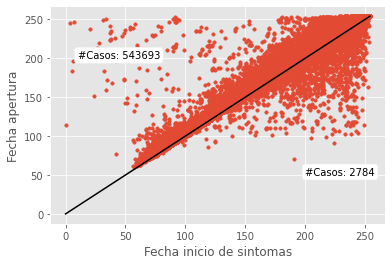

In [7]:
plt.scatter(fecha_sintomas,fecha_apertura,s=12)
xaux = np.linspace(min(fecha_sintomas),max(fecha_sintomas),1000)
props = dict(boxstyle='round', facecolor='white')
plt.text(200,50,"#Casos: "+str(sum(fecha_sintomas > fecha_apertura)),bbox=props)
plt.text(10,200,"#Casos: "+str(sum(fecha_sintomas <= fecha_apertura)),bbox=props)
plt.xlabel("Fecha inicio de sintomas")
plt.ylabel("Fecha apertura")
plt.plot(xaux,xaux,c='k')
#plt.savefig("fechas.pdf")

# cases nationwide (total cases whose symptoms began on day x)

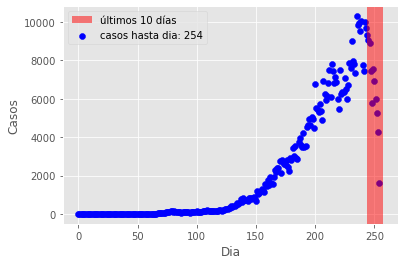

In [9]:
#here we count the amount of cases per day
counts = np.bincount(fecha_sintomas)
aux = range(ultima_fecha+1)
casos_por_dia = np.vstack((aux,counts[aux])).T #(days since inicio_epidemia x (fecha_inicio_sintomas == days))
plt.xlabel("Dia")
plt.ylabel("Casos")
plt.axvspan(ultima_fecha-10, ultima_fecha+3, facecolor='r', alpha=0.5,label="últimos 10 días")
plt.scatter(casos_por_dia[:,0],casos_por_dia[:,1],c='b',label="casos hasta dia: "+str(ultima_fecha))
plt.legend()
#plt.savefig("casos_por_dia_dia254.pdf")

# cumulative cases (summing up to day x all the days before)

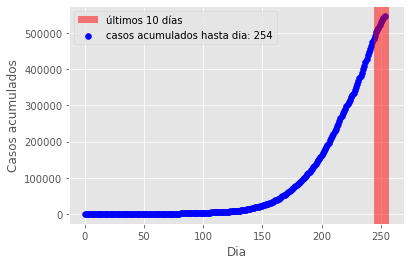

In [10]:
casos_acumulados_por_dia = np.copy(casos_por_dia)
casos_acumulados_por_dia[:,1] = np.cumsum(casos_por_dia[:,1]) 
#here we count the cumulative of cases per day
plt.xlabel("Dia")
plt.ylabel("Casos acumulados")
plt.axvspan(ultima_fecha-10, ultima_fecha+3, facecolor='r', alpha=0.5,label="últimos 10 días")
plt.scatter(casos_acumulados_por_dia[:,0],casos_acumulados_por_dia[:,1],c='b',label="casos acumulados hasta dia: "+str(ultima_fecha))
plt.legend()
#plt.savefig("casos_acumulados_por_dia_dia254.pdf")

C:\Users\denis\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


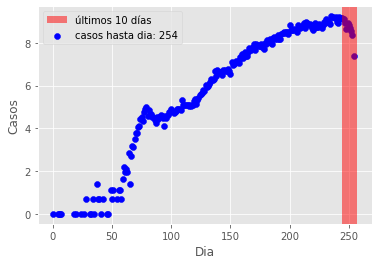

In [11]:
#log cases - days since beginning
plt.xlabel("Dia")
plt.ylabel("Casos")
plt.axvspan(ultima_fecha-10, ultima_fecha+3, facecolor='r', alpha=0.5,label="últimos 10 días")
plt.scatter(casos_por_dia[:,0],np.log(casos_por_dia[:,1]),c='b',label="casos hasta dia: "+str(ultima_fecha))
plt.legend()
plt.savefig('casos_log.pdf')

# duplication time fitting 

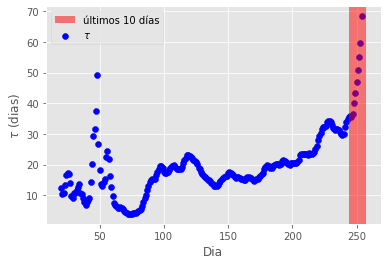

In [13]:
#now we have the cumulative cases, we can try to calculate duplication time as the gov. does
#what we learn here will be useful (with class organizing later) to calculate Rt later
log_casos_acumulados = np.copy(casos_acumulados_por_dia) 
log_casos_acumulados = log_casos_acumulados.astype(float) #cast to float calculation for log afterwards
log_casos_acumulados[:,1] = np.log(log_casos_acumulados[:,1]) #log of cumulative cases
tiempos_duplicacion = np.copy(log_casos_acumulados) #storing duplication times
dias = np.copy(log_casos_acumulados[:,0]) #array of all days
dias = dias[dias>=6] #array of valid days (>= 7 days)
dias = dias.astype(int) #string casting to use as index
ventana_dias = 6 #define window of days to fit (its this + 1)
model = LinearRegression() #object of sklearn to fit data
#for each valid day fitting and getting slope
for i in dias:
    #formating correct for using fit sklearn 
    x_fit = log_casos_acumulados[i-ventana_dias:i+1,0].reshape((-1,1))
    y_fit = log_casos_acumulados[i-ventana_dias:i+1,1]
    model.fit(x_fit,y_fit) #perform fitting
    tiempos_duplicacion[i,1] = model.coef_
#transforming slope to duplication time
tiempos_duplicacion = tiempos_duplicacion[20:,:] #since >= 20 days bc otherwise it goes to infty
tiempos_duplicacion[:,1] = np.log(2)/(tiempos_duplicacion[:,1]) #transforming to duplication time
plt.axvspan(ultima_fecha-10, ultima_fecha+3, facecolor='r', alpha=0.5,label="últimos 10 días")
plt.scatter(tiempos_duplicacion[:,0],tiempos_duplicacion[:,1],c='b',label=r'$\tau$')
plt.xlabel("Dia")
plt.ylabel(r'$\tau$ (dias)',fontsize=12)
plt.legend()
#plt.savefig("duplicacion_casos.pdf")

# calculating Rt empirical for days 6-present day

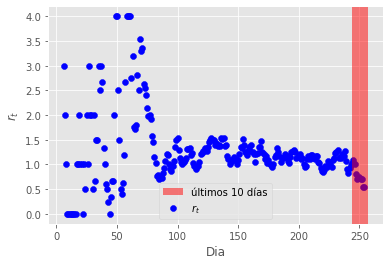

In [45]:
n_t = np.copy(casos_por_dia) #here we store data + proyection for day t+1 
#casting r_t y n_t to floats to be able to divide, multiply,etc and have floats as results
n_t = n_t.astype(float)
#aux variable
ultimo_dia = r_t.shape[0] 
#completion to calculate with new cases, based on the mean of the last days
#instead of interpolation that apparently isnt much better really
aux = np.zeros(2)
i = 0
while i < 4: #completing until the day t+4 bc im gonna need it later for averaging in 7 days
    aux[0] = ultimo_dia + i
    aux[1] = np.mean(n_t[ultimo_dia-7:,1])
    n_t  = np.vstack((n_t,aux)) #extending n_t up to day t+1
    i= i +1
#create storage and calculate values for r_t
r_t = np.copy(n_t) #here we will store the rt
r_t = r_t.astype(float)
#calculating r_t
dias_aux = np.arange(0,ultimo_dia+3)
dias_aux = dias_aux[dias_aux>=6]
for i in dias_aux:
    aux = n_t[i-6,1] + n_t[i-5,1] + n_t[i-4,1] #denominator of the r_t expression
    if(aux==0):
        aux = 1 #the first cases in which the denominator is == 0
    r_t[i,1] = min(((n_t[i-1,1] + n_t[i,1] + n_t[i+1,1])/(aux)),4) #the rest of the days
#grafico r_t en funcion de los dias t
plt.axvspan(ultima_fecha-10, ultima_fecha+3, facecolor='r', alpha=0.5,label="últimos 10 días")
plt.scatter(r_t[6:ultimo_dia,0],r_t[6:ultimo_dia,1],c='b',label=r'$r_t$')
plt.xlabel("Dia")
plt.ylabel(r'$r_t$',fontsize=12)
plt.legend()
plt.savefig("rt_raw_casos.pdf")

# calculating whats necessary for the risk diagram for 9-present day

Text(0.5, 1.0, 'Diagrama de riesgo nacional')

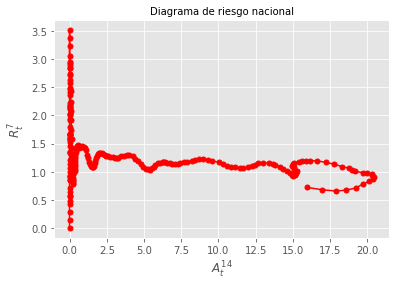

In [97]:
#we proceed to calculate what makes a risk diagram then
#first, we will calculate r_t average in 7 days
r_t_seven = np.zeros(ultimo_dia-9)
i = 9
while i < ultimo_dia:
    r_t_seven[i-9] = np.mean(r_t[i-3:i+4,1])
    i = i+1
#dias_seven = np.arange(9,ultimo_dia,1)
#plt.plot(dias_seven,r_t_seven) decomment to plot out of curiosity
#second, we calculate the attack ratio (translation?)
pop_arg = 44361150 #argentina number inhabitants acc to wikipedia
i = 13
a_t = np.zeros(ultimo_dia-13)
while i < ultimo_dia:
    a_t[i-13] = np.mean(n_t[i-13:i+1,1])
    i = i+1
a_t = a_t * (100000/pop_arg)
plt.plot(a_t,r_t_seven[4:],'-or',markersize=5) #not at all fancy risk diagram,looks reasonable
plt.xlabel(r'$A_{t}^{14}$')
plt.ylabel(r'$R_{t}^{7}$')
plt.title('Diagrama de riesgo nacional',fontsize=10)
#plt.savefig('riskdiagram_simple.pdf')

# and now we're down to predicting things this way

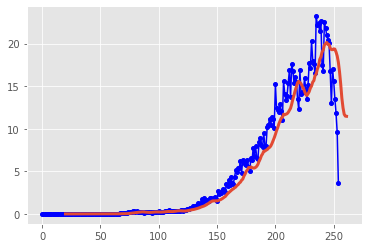

In [129]:
r_def = r_t_seven[4:]
p_t = np.zeros(ultimo_dia-13)
p_t = r_def * a_t
dias_p = np.arange(20,ultimo_dia+7,1)
plt.plot(casos_por_dia[:,0],casos_por_dia[:,1]*(100000/pop_arg),'-ob',markersize=4,label="casos hasta dia: "+str(ultima_fecha))
plt.plot(dias_p,p_t,linewidth=3)